### Escenario 1: Dataset completo

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

#### 1 Carga del Dataset

In [2]:
#data_esc1 = pd.read_csv("/content/drive/MyDrive/Colab_Tesis/Churn_Modelling_escenario1.csv")
data_esc1 = pd.read_csv("datasets/Churn_Modelling_escenario1.csv")

In [3]:
data_esc1.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_encoded,Gender_encoded
0,619,42,2,0.00,1,1,1,101348.88,1,2,1
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,2,1


In [4]:
data_esc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_encoded  10000 non-null  int64  
 10  Gender_encoded     10000 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 859.5 KB


In [5]:
# División del dataset en entrenamiento y prueba

features = data_esc1.drop("Exited", axis=1)
target = data_esc1["Exited"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

#### 2 Balanceo de Datos con Oversampling y Undersampling

##### 2.1. Balanceo de Datos con Oversampling (SMOTE)

In [6]:
smote_esc1 = SMOTE(random_state=42)
X_train_over, y_train_over = smote_esc1.fit_resample(X_train, y_train)

print('Distribución de clases antes del oversampling:', Counter(y_train))
print('Distribución de clases después del oversampling:', Counter(y_train_over))

Distribución de clases antes del oversampling: Counter({0: 5547, 1: 1453})
Distribución de clases después del oversampling: Counter({1: 5547, 0: 5547})


##### 2.2 Balanceo de Datos con Undersampling

In [7]:
rus_esc1 = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus_esc1.fit_resample(X_train, y_train)

#### 3 Estandarización de los Datos



In [8]:
# Se realiza el proceso de estandarización de las características (features)
escalado = StandardScaler()

# Se estandariza el conjunto de datos original (desbalanceado)
X_train_std_esc1 = escalado.fit_transform(X_train)
X_test_std_esc1 = escalado.transform(X_test)

# Se estandariza el conjunto de datos con Oversampling
X_train_over_std_esc1 = escalado.fit_transform(X_train_over)
X_test_over_std_esc1 = escalado.transform(X_test)

# Se estandariza el conjunto de datos con Undersampling
X_train_under_std_esc1 = escalado.fit_transform(X_train_under)
X_test_under_std_esc1 = escalado.transform(X_test)

#### 4 Entrenamiento y Evaluación del Modelo

##### 4.1. Aplicamos el modelo de Random Forest

In [9]:
# Se configura el modelo de Random Forest y los hiperparámetros para GridSearch
rf_esc1 = RandomForestClassifier(random_state=42)

parametros_grid_rf_esc1 = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configuración de GridSearch
grid_search_rf_esc1 = GridSearchCV(estimator=rf_esc1,
                           param_grid=parametros_grid_rf_esc1,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy'
                           )

##### 4.1.1. Modelo con Datos Desbalanceados - Random Forest

In [10]:
grid_search_rf_esc1.fit(X_train_std_esc1, y_train)
# Mejor modelo de Random Forest
best_rf_esc1 = grid_search_rf_esc1.best_estimator_
print(best_rf_esc1)

# Predicciones y evaluación
y_pred_rf_esc1 = best_rf_esc1.predict(X_test_std_esc1)
y_prob_rf_esc1 = best_rf_esc1.predict_proba(X_test_std_esc1)[:, 1]
print("Evaluación con datos desbalanceados:")
print(confusion_matrix(y_test, y_pred_rf_esc1))
print(classification_report(y_test, y_pred_rf_esc1))

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=42)
Evaluación con datos desbalanceados:
[[2343   73]
 [ 317  267]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.79      0.46      0.58       584

    accuracy                           0.87      3000
   macro avg       0.83      0.71      0.75      3000
weighted avg       0.86      0.87      0.86      3000



##### 4.1.2. Modelo con Oversamplig - Random Forest

In [11]:
# Se entrena y evalúa el modelo con datos balanceados por oversampling
grid_search_rf_esc1.fit(X_train_over_std_esc1, y_train_over)
# Mejor modelo de Random Forest con oversampling
best_rf_over_esc1 = grid_search_rf_esc1.best_estimator_
print(best_rf_over_esc1)

# Predicciones y evaluación
y_pred_rf_over_esc1 = best_rf_over_esc1.predict(X_test_over_std_esc1)
y_prob_rf_over_esc1 = best_rf_over_esc1.predict_proba(X_test_over_std_esc1)[:, 1]
print("Evaluación con Oversampling (SMOTE):")
print(confusion_matrix(y_test, y_pred_rf_over_esc1))
print(classification_report(y_test, y_pred_rf_over_esc1))

RandomForestClassifier(max_depth=30, random_state=42)
Evaluación con Oversampling (SMOTE):
[[2108  308]
 [ 214  370]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      2416
           1       0.55      0.63      0.59       584

    accuracy                           0.83      3000
   macro avg       0.73      0.75      0.74      3000
weighted avg       0.84      0.83      0.83      3000



##### 4.1.3 Modelo con Undersampling - Random Forest

In [12]:
# Entrenar y evaluar el modelo con datos balanceados por undersampling
grid_search_rf_esc1.fit(X_train_under_std_esc1, y_train_under)
best_rf_under_esc1 = grid_search_rf_esc1.best_estimator_
print(best_rf_under_esc1)

# Predicciones y evaluación
y_pred_rf_under_esc1 = best_rf_under_esc1.predict(X_test_under_std_esc1)
y_prob_rf_under_esc1 = best_rf_under_esc1.predict_proba(X_test_under_std_esc1)[:, 1]
print("Evaluación con Undersampling:")
print(confusion_matrix(y_test, y_pred_rf_under_esc1))
print(classification_report(y_test, y_pred_rf_under_esc1))

RandomForestClassifier(max_depth=10, min_samples_leaf=2, random_state=42)
Evaluación con Undersampling:
[[1913  503]
 [ 141  443]]
              precision    recall  f1-score   support

           0       0.93      0.79      0.86      2416
           1       0.47      0.76      0.58       584

    accuracy                           0.79      3000
   macro avg       0.70      0.78      0.72      3000
weighted avg       0.84      0.79      0.80      3000



##### 5.1. Aplicamos el modelo de Regresión Logística

In [13]:
# Se configura el modelo de Regresión Logística y los hiperparámetros para GridSearch

reglog_esc1 = LogisticRegression(random_state=42)

parametros_grid_reglog_esc1 = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'sag'],
    'max_iter': [100, 200, 300, 500]
}

# Configuración de GridSearch
grid_search_reglog_esc1 = GridSearchCV(reglog_esc1,
                           param_grid=parametros_grid_reglog_esc1,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy')

##### 5.1.1. Modelo con Datos Desbalanceados - Regresión Logística

In [14]:
grid_search_reglog_esc1.fit(X_train_std_esc1, y_train)
# Mejor modelo de Random Forest
best_reglog_esc1 = grid_search_reglog_esc1.best_estimator_
print(best_reglog_esc1)

# Predicciones y evaluación
y_pred_reglog_esc1 = best_reglog_esc1.predict(X_test_std_esc1)
y_prob_reglog_esc1 = best_reglog_esc1.predict_proba(X_test_std_esc1)[:, 1]
print("Evaluación con datos desbalanceados:")
print(confusion_matrix(y_test, y_pred_reglog_esc1))
print(classification_report(y_test, y_pred_reglog_esc1))

LogisticRegression(C=1, random_state=42, solver='liblinear')
Evaluación con datos desbalanceados:
[[2349   67]
 [ 483  101]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      2416
           1       0.60      0.17      0.27       584

    accuracy                           0.82      3000
   macro avg       0.72      0.57      0.58      3000
weighted avg       0.79      0.82      0.77      3000



##### 5.1.2. Modelo con Oversamplig - Regresión Logística

In [15]:
# Se entrena y evalúa el modelo con datos balanceados por oversampling
grid_search_reglog_esc1.fit(X_train_over_std_esc1, y_train_over)
best_reglog_over_esc1 = grid_search_reglog_esc1.best_estimator_
print(best_reglog_over_esc1)

# Predicciones y evaluación
y_pred_reglog_over_esc1 = best_reglog_over_esc1.predict(X_test_over_std_esc1)
y_prob_reglog_over_esc1 = best_reglog_over_esc1.predict_proba(X_test_over_std_esc1)[:, 1]
print("Evaluación con Oversampling")
print(confusion_matrix(y_test, y_pred_reglog_over_esc1))
print(classification_report(y_test, y_pred_reglog_over_esc1))

LogisticRegression(C=0.1, random_state=42, solver='liblinear')
Evaluación con Oversampling
[[1780  636]
 [ 247  337]]
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      2416
           1       0.35      0.58      0.43       584

    accuracy                           0.71      3000
   macro avg       0.61      0.66      0.62      3000
weighted avg       0.77      0.71      0.73      3000



##### 5.1.3 Modelo con Undersampling - Regresión Logística

In [16]:
# Se entrena y evalúa el modelo con datos balanceados por undersampling
grid_search_reglog_esc1.fit(X_train_under_std_esc1, y_train_under)
best_reglog_under_esc1 = grid_search_reglog_esc1.best_estimator_
print(best_reglog_under_esc1)

# Prediciones y evaluación
y_pred_reglog_under_esc1 = best_reglog_under_esc1.predict(X_test_under_std_esc1)
y_prob_reglog_under_esc1 = best_reglog_under_esc1.predict_proba(X_test_under_std_esc1)[:, 1]
print("Evaluación con Undersampling")
print(confusion_matrix(y_test, y_pred_reglog_under_esc1))
print(classification_report(y_test, y_pred_reglog_under_esc1))

LogisticRegression(C=1, random_state=42, solver='liblinear')
Evaluación con Undersampling
[[1698  718]
 [ 187  397]]
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      2416
           1       0.36      0.68      0.47       584

    accuracy                           0.70      3000
   macro avg       0.63      0.69      0.63      3000
weighted avg       0.79      0.70      0.73      3000



##### 6.1. Aplicamos el modelo de SVM

In [17]:
# Se configura el modelo de SVM y los hiperparámetros para GridSearch
svc_esc1 = SVC(random_state = 42, probability=True)

parametros_grid_svc_esc1 = {
    'C': [1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly']
}

# Configuración de GridSearch
grid_search_svc_esc1 = GridSearchCV(estimator=svc_esc1,
                                    param_grid=parametros_grid_svc_esc1,
                                    cv=5,
                                    n_jobs=-1,
                                    scoring='accuracy')

##### 6.1.1. Modelo con Datos Desbalanceados - SVM

In [18]:
grid_search_svc_esc1.fit(X_train_std_esc1, y_train)

# Mejor modelo con SVM
best_svc_esc1 = grid_search_svc_esc1.best_estimator_
print(best_svc_esc1)

# Prediciones y evaluación
y_pred_svc_esc1 = best_svc_esc1.predict(X_test_std_esc1)
y_prob_svc_esc1 = best_svc_esc1.predict_proba(X_test_std_esc1)[:, 1]
print("Evaluación con los datos desbalanceados")
print(confusion_matrix(y_test, y_pred_svc_esc1))
print(classification_report(y_test, y_pred_svc_esc1))

SVC(C=1, probability=True, random_state=42)
Evaluación con los datos desbalanceados
[[2372   44]
 [ 367  217]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2416
           1       0.83      0.37      0.51       584

    accuracy                           0.86      3000
   macro avg       0.85      0.68      0.72      3000
weighted avg       0.86      0.86      0.84      3000



##### 6.1.2. Modelo con Oversamplig - SVM

In [19]:
# Se entrena y evalúa el modelo con datos balanceados por oversampling
grid_search_svc_esc1.fit(X_train_over_std_esc1, y_train_over)
best_svc_over_esc1 = grid_search_svc_esc1.best_estimator_
print(best_svc_over_esc1)

# Predicciones y evaluación
y_pred_svc_over_esc1 = best_svc_over_esc1.predict(X_test_over_std_esc1)
y_prob_svc_over_esc1 = best_svc_over_esc1.predict_proba(X_test_over_std_esc1)[:, 1]
print("Evaluación con Oversampling")
print(confusion_matrix(y_test, y_pred_svc_over_esc1))
print(classification_report(y_test, y_pred_svc_over_esc1))

SVC(C=10, gamma='auto', probability=True, random_state=42)
Evaluación con Oversampling
[[1983  433]
 [ 193  391]]
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      2416
           1       0.47      0.67      0.56       584

    accuracy                           0.79      3000
   macro avg       0.69      0.75      0.71      3000
weighted avg       0.83      0.79      0.80      3000



##### 6.1.3 Modelo con Undersampling - SVM

In [20]:
# Se entrena y evalúa el modelo con datos balanceados por undersampling
grid_search_svc_esc1.fit(X_train_under_std_esc1, y_train_under)
best_svc_under_esc1 = grid_search_svc_esc1.best_estimator_
print(best_svc_under_esc1)

# Predicciones y evaluación
y_pred_svc_under_esc1 = best_svc_under_esc1.predict(X_test_under_std_esc1)
y_prob_svc_under_esc1 = best_svc_under_esc1.predict_proba(X_test_under_std_esc1)[:, 1]
print("Evaluación con Undersampling")
print(confusion_matrix(y_test, y_pred_svc_under_esc1))
print(classification_report(y_test, y_pred_svc_under_esc1))

SVC(C=1, probability=True, random_state=42)
Evaluación con Undersampling
[[1818  598]
 [ 143  441]]
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      2416
           1       0.42      0.76      0.54       584

    accuracy                           0.75      3000
   macro avg       0.68      0.75      0.69      3000
weighted avg       0.83      0.75      0.77      3000



##### 7.1. Aplicamos el modelo de Árboles de Decisión

In [21]:
# Se configura el modelo de Árboles de Decisión y los hiperparámetros para GridSearch
dt_esc1 = DecisionTreeClassifier(random_state = 42)

parametros_grid_dt_esc1 = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ["gini", "entropy"],
    'max_features': ["sqrt", "log2"]
}

# Configuración de GridSearch
grid_search_dt_esc1 = GridSearchCV(estimator=dt_esc1,
                                  param_grid=parametros_grid_dt_esc1,
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='accuracy')

##### 7.1.1. Modelo con Datos Desbalanceados - Árboles de Decisión

In [22]:
grid_search_dt_esc1.fit(X_train_std_esc1, y_train)

# Mejor modelo con Árboles de Decisión
best_dt_esc1 = grid_search_dt_esc1.best_estimator_
print(best_dt_esc1)

# Predicciones y evaluación
y_pred_dt_esc1 = best_dt_esc1.predict(X_test_std_esc1)
y_prob_dt_esc1 = best_dt_esc1.predict_proba(X_test_std_esc1)[:, 1]
print("Evaluación con los datos desbalanceados")
print(confusion_matrix(y_test, y_pred_dt_esc1))
print(classification_report(y_test, y_pred_dt_esc1))

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       random_state=42)
Evaluación con los datos desbalanceados
[[2269  147]
 [ 333  251]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2416
           1       0.63      0.43      0.51       584

    accuracy                           0.84      3000
   macro avg       0.75      0.68      0.71      3000
weighted avg       0.83      0.84      0.83      3000



##### 7.1.2. Modelo con Oversamplig - Árboles de Decisión

In [23]:
# Se entrena y evalúa el modelo con datos balanceados por oversampling
grid_search_dt_esc1.fit(X_train_over_std_esc1, y_train_over)
best_dt_over_esc1 = grid_search_dt_esc1.best_estimator_
print(best_dt_over_esc1)

# Predicciones y evaluación
y_pred_dt_over_esc1 = best_dt_over_esc1.predict(X_test_over_std_esc1)
y_prob_dt_over_esc1 = best_dt_over_esc1.predict_proba(X_test_over_std_esc1)[:, 1]
print("Evaluación con Oversampling")
print(confusion_matrix(y_test, y_pred_dt_over_esc1))
print(classification_report(y_test, y_pred_dt_over_esc1))

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       random_state=42)
Evaluación con Oversampling
[[1870  546]
 [ 204  380]]
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      2416
           1       0.41      0.65      0.50       584

    accuracy                           0.75      3000
   macro avg       0.66      0.71      0.67      3000
weighted avg       0.81      0.75      0.77      3000



##### 7.1.3 Modelo con Undersampling - Árboles de Decisión

In [24]:
# Se entrena y evalúa el modelo con datos balanceados por undersampling
grid_search_dt_esc1.fit(X_train_under_std_esc1, y_train_under)
best_dt_under_esc1 = grid_search_dt_esc1.best_estimator_
print(best_dt_under_esc1)

# Predicciones y evaluación
y_pred_dt_under_esc1 = best_dt_under_esc1.predict(X_test_under_std_esc1)
y_prob_dt_under_esc1 = best_dt_under_esc1.predict_proba(X_test_under_std_esc1)[:, 1]
print("Evaluación con Undersampling")
print(confusion_matrix(y_test, y_pred_dt_under_esc1))
print(classification_report(y_test, y_pred_dt_under_esc1))

DecisionTreeClassifier(max_depth=10, max_features='sqrt', random_state=42)
Evaluación con Undersampling
[[1620  796]
 [ 140  444]]
              precision    recall  f1-score   support

           0       0.92      0.67      0.78      2416
           1       0.36      0.76      0.49       584

    accuracy                           0.69      3000
   macro avg       0.64      0.72      0.63      3000
weighted avg       0.81      0.69      0.72      3000



#### 8.1. Aplicamos el modelo de Red Neuronal MLP

In [25]:
# Configurar el modelo de una Red Neuronal MLP y los hiperparámetros para GridSearch
mlp_esc1 = MLPClassifier(random_state=42, max_iter=2000)

parametros_grid_mlp_esc1 = {
    'hidden_layer_sizes': [(50,)],
    'activation': ['relu'],
    'solver': ['sgd','adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['adaptive', 'constant']
}
# Usar GridSearchCV para encontrar los mejores hiperparámetros
grid_search_mlp_esc1 = GridSearchCV(estimator=mlp_esc1,
                                    param_grid=parametros_grid_mlp_esc1,
                                    cv=5,
                                    scoring='accuracy')

##### 8.1.1. Modelo con Datos Desbalanceados - Red Neuronal MLP

In [26]:
# Se realiza el entrenamiento del modelo con datos desbalanceados
grid_search_mlp_esc1.fit(X_train_std_esc1, y_train)

# Mejor modelo MLP
best_mlp_esc1 = grid_search_mlp_esc1.best_estimator_
print(best_mlp_esc1)

# Predicciones y evaluación
y_pred_mlp_esc1 = best_mlp_esc1.predict(X_test_std_esc1)
y_prob_mlp_esc1 = best_mlp_esc1.predict_proba(X_test_std_esc1)[:, 1]
print("Evaluación con datos desbalanceados:")
print(confusion_matrix(y_test, y_pred_mlp_esc1))
print(classification_report(y_test, y_pred_mlp_esc1))

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50,), learning_rate='adaptive',
              max_iter=2000, random_state=42)
Evaluación con datos desbalanceados:
[[2316  100]
 [ 299  285]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2416
           1       0.74      0.49      0.59       584

    accuracy                           0.87      3000
   macro avg       0.81      0.72      0.75      3000
weighted avg       0.86      0.87      0.86      3000



##### 8.1.2. Modelo con Oversamplig - Red Neuronal MLP

In [27]:
# Se realiza el entrenamiento del modelo con datos balanceados por oversampling
grid_search_mlp_esc1.fit(X_train_over_std_esc1, y_train_over)
best_mlp_over_esc1 = grid_search_mlp_esc1.best_estimator_
print(best_mlp_over_esc1)

# Predicciones y evaluación
y_pred_mlp_over_esc1 = best_mlp_over_esc1.predict(X_test_over_std_esc1)
y_prob_mlp_over_esc1 = best_mlp_over_esc1.predict_proba(X_test_over_std_esc1)[:, 1]
print("Evaluación con Oversampling (SMOTE):")
print(confusion_matrix(y_test, y_pred_mlp_over_esc1))
print(classification_report(y_test, y_pred_mlp_over_esc1))

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50,), learning_rate='adaptive',
              max_iter=2000, random_state=42)
Evaluación con Oversampling (SMOTE):
[[1943  473]
 [ 172  412]]
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      2416
           1       0.47      0.71      0.56       584

    accuracy                           0.79      3000
   macro avg       0.69      0.75      0.71      3000
weighted avg       0.83      0.79      0.80      3000



##### 8.1.3 Modelo con Undersampling - Red Neuronal MLP

In [28]:
# Se realiza el entrenamiento del modelo con datos balanceados por undersampling
grid_search_mlp_esc1.fit(X_train_under_std_esc1, y_train_under)
best_mlp_under_esc1 = grid_search_mlp_esc1.best_estimator_
print(best_mlp_under_esc1)

# Predicciones y evaluación
y_pred_mlp_under_esc1 = best_mlp_under_esc1.predict(X_test_under_std_esc1)
y_prob_mlp_under_esc1 = best_mlp_under_esc1.predict_proba(X_test_under_std_esc1)[:, 1]
print("Evaluación con Undersampling:")
print(confusion_matrix(y_test, y_pred_mlp_under_esc1))
print(classification_report(y_test, y_pred_mlp_under_esc1))

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50,), max_iter=2000,
              random_state=42, solver='sgd')
Evaluación con Undersampling:
[[1815  601]
 [ 144  440]]
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      2416
           1       0.42      0.75      0.54       584

    accuracy                           0.75      3000
   macro avg       0.67      0.75      0.69      3000
weighted avg       0.83      0.75      0.77      3000



#### 9.1. Aplicamos el algoritmo XGBoost

In [29]:
# Se configura el modelo XGBoost y los hiperparámetros para GridSearch
xgboost_esc1 = XGBClassifier(random_state=42)
parametros_grid_xgb_esc1 = {
    'n_estimators': [100, 150, 200],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1, 1]
}

# Se usa GridSearchCV para encontrar los mejores hiperparámetros
grid_search_xgb_esc1 = GridSearchCV(estimator=xgboost_esc1,
                                    param_grid=parametros_grid_xgb_esc1,
                                    cv=5,
                                    scoring='accuracy')

##### 9.1.1. Modelo con Datos Desbalanceados - XGBoost

In [30]:
grid_search_xgb_esc1.fit(X_train_std_esc1, y_train)

# Mejor modelo XGBoost
best_xgb_esc1 = grid_search_xgb_esc1.best_estimator_
print(best_xgb_esc1)

# Predicciones y evaluación
y_pred_xgb_esc1 = best_xgb_esc1.predict(X_test_std_esc1)
y_prob_xgb_esc1 = best_xgb_esc1.predict_proba(X_test_std_esc1)[:, 1]
print("Evaluación con datos desbalanceados:")
print(confusion_matrix(y_test, y_pred_xgb_esc1))
print(classification_report(y_test, y_pred_xgb_esc1))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
Evaluación con datos desbalanceados:
[[2331   85]
 [ 306  278]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2416
           1       0.77      0.48      0.59       584

    accuracy    

##### 9.1.2. Modelo con Oversamplig - XGBoost

In [31]:
# Se entrena y evalúa el modelo con datos balanceados por oversampling
grid_search_xgb_esc1.fit(X_train_over_std_esc1, y_train_over)
best_xgb_over_esc1 = grid_search_xgb_esc1.best_estimator_
print(best_xgb_over_esc1)

# Predicciones y evaluación
y_pred_xgb_over_esc1 = best_xgb_over_esc1.predict(X_test_over_std_esc1)
y_prob_xgb_over_esc1 = best_xgb_over_esc1.predict_proba(X_test_over_std_esc1)[:, 1]
print("Evaluación con Oversampling")
print(confusion_matrix(y_test, y_pred_xgb_over_esc1))
print(classification_report(y_test, y_pred_xgb_over_esc1))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)
Evaluación con Oversampling
[[2047  369]
 [ 243  341]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      2416
           1       0.48      0.58      0.53       584

    accuracy               

##### 9.1.3 Modelo con Undersampling - XGBoost

In [32]:
# Se entrena y evalúa el modelo con datos balanceados por undersampling
grid_search_xgb_esc1.fit(X_train_under_std_esc1, y_train_under)
best_xgb_under_esc1 = grid_search_xgb_esc1.best_estimator_
print(best_xgb_under_esc1)

# Predicciones y evaluación
y_pred_xgb_under_esc1 = best_xgb_under_esc1.predict(X_test_under_std_esc1)
y_prob_xgb_under_esc1 = best_xgb_under_esc1.predict_proba(X_test_under_std_esc1)[:, 1]
print("Evaluación con Undersampling")
print(confusion_matrix(y_test, y_pred_xgb_under_esc1))
print(classification_report(y_test, y_pred_xgb_under_esc1))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
Evaluación con Undersampling
[[1932  484]
 [ 154  430]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2416
           1       0.47      0.74      0.57       584

    accuracy            

#### 10.1. Aplicamos el algoritmo AdaBoost

In [33]:
# Se configura el modelo AdaBoost y los hiperparámetros para GridSearch
adaboost_esc1 = AdaBoostClassifier(random_state=42)
param_grid_adaboost_esc1 = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Usar GridSearchCV para encontrar los mejores hiperparámetros
grid_search_adaboost_esc1 = GridSearchCV(estimator=adaboost_esc1,
                                        param_grid=param_grid_adaboost_esc1,
                                        cv=5,
                                        scoring='accuracy')

##### 10.1.1. Modelo con Datos Desbalanceados - AdaBoost

In [34]:
# Se realiza el modelo con datos desbalanceados
grid_search_adaboost_esc1.fit(X_train_std_esc1, y_train)

# Mejor modelo AdaBoost
best_adaboost_esc1 = grid_search_adaboost_esc1.best_estimator_
print(best_adaboost_esc1)

# Predicciones y evaluación
y_pred_adaboost_esc1 = best_adaboost_esc1.predict(X_test_std_esc1)
y_prob_adaboost_esc1 = best_adaboost_esc1.predict_proba(X_test_std_esc1)[:, 1]
print("Evaluación con datos desbalanceados:")
print(confusion_matrix(y_test, y_pred_adaboost_esc1))
print(classification_report(y_test, y_pred_adaboost_esc1))


AdaBoostClassifier(random_state=42)
Evaluación con datos desbalanceados:
[[2319   97]
 [ 321  263]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2416
           1       0.73      0.45      0.56       584

    accuracy                           0.86      3000
   macro avg       0.80      0.71      0.74      3000
weighted avg       0.85      0.86      0.85      3000



##### 10.1.2. Modelo con Oversamplig - AdaBoost

In [35]:
# Se entrena y evalúa el modelo con datos balanceados por oversampling
grid_search_adaboost_esc1.fit(X_train_over_std_esc1, y_train_over)
best_adaboost_over_esc1 = grid_search_adaboost_esc1.best_estimator_
print(best_adaboost_over_esc1)

# Predicciones y evaluación
y_pred_adaboost_over_esc1 = best_adaboost_over_esc1.predict(X_test_over_std_esc1)
y_prob_adaboost_over_esc1 = best_adaboost_over_esc1.predict_proba(X_test_under_std_esc1)[:, 1]
print("Evaluación con Oversampling")
print(confusion_matrix(y_test, y_pred_adaboost_over_esc1))
print(classification_report(y_test, y_pred_adaboost_over_esc1))

AdaBoostClassifier(n_estimators=200, random_state=42)
Evaluación con Oversampling
[[1987  429]
 [ 176  408]]
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      2416
           1       0.49      0.70      0.57       584

    accuracy                           0.80      3000
   macro avg       0.70      0.76      0.72      3000
weighted avg       0.83      0.80      0.81      3000



##### 10.1.3 Modelo con Undersampling - AdaBoost

In [36]:
# Se entrena y evalúa el modelo con datos balanceados por undersampling
grid_search_adaboost_esc1.fit(X_train_under_std_esc1, y_train_under)
best_adaboost_under_esc1 = grid_search_adaboost_esc1.best_estimator_
print(best_adaboost_under_esc1)

# Predicciones y evaluación
y_pred_adaboost_under_esc1 = best_adaboost_under_esc1.predict(X_test_under_std_esc1)
y_prob_adaboost_under_esc1 = best_adaboost_under_esc1.predict_proba(X_test_under_std_esc1)[:, 1]
print("Evaluación con Undersampling")
print(confusion_matrix(y_test, y_pred_adaboost_under_esc1))
print(classification_report(y_test, y_pred_adaboost_under_esc1))

AdaBoostClassifier(n_estimators=100, random_state=42)
Evaluación con Undersampling
[[1848  568]
 [ 127  457]]
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      2416
           1       0.45      0.78      0.57       584

    accuracy                           0.77      3000
   macro avg       0.69      0.77      0.70      3000
weighted avg       0.84      0.77      0.79      3000



In [37]:
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import layers
from keras import models
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

#### Aplicamos el modelo de una Red Neuronal Profunda (DNN)

In [38]:
import tensorflow as tf
import numpy as np

# Establecer semilla aleatoria para garantizar resultados reproducibles
np.random.seed(42)  # Para operaciones que dependen de NumPy
tf.random.set_seed(42)  # Para TensorFlow

In [39]:
# Definir y entrenar el modelo DNN
model = keras.Sequential()
model.add(layers.Dense(64, input_dim=X_train_std_esc1.shape[1], activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

c:\Users\rdcastillo47\Documents\RAHAM_UNIVERSIDAD\HERRAMIENTAS\appSIFIA_copia\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# Compilación y entrenamiento
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_std_esc1, y_train, epochs=10, batch_size=16, validation_split=0.2)

# Evaluación
y_pred = model.predict(X_test_std_esc1)
y_pred_etiquetas = (y_pred > 0.5)  # Convertir probabilidades en etiquetas
print(confusion_matrix(y_test, y_pred_etiquetas))
print(classification_report(y_test, y_pred_etiquetas))

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7600 - loss: 0.5040 - val_accuracy: 0.8407 - val_loss: 0.3932
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8353 - loss: 0.3891 - val_accuracy: 0.8450 - val_loss: 0.3684
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.3670 - val_accuracy: 0.8471 - val_loss: 0.3614
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8469 - loss: 0.3589 - val_accuracy: 0.8479 - val_loss: 0.3587
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8534 - loss: 0.3527 - val_accuracy: 0.8507 - val_loss: 0.3567
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8540 - loss: 0.3473 - val_accuracy: 0.8529 - val_loss: 0.3544
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8559 - loss: 0.3431 - val_accuracy: 0.8514 - val_loss: 0.3534
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8555 - loss: 0.3393 - val_accuracy: 0.

In [41]:
print(classification_report(y_test, y_pred_etiquetas))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.77      0.43      0.55       584

    accuracy                           0.86      3000
   macro avg       0.82      0.70      0.74      3000
weighted avg       0.85      0.86      0.85      3000



##### 4.2. Aplicamos el modelo de una Red Neuronal Profunda (DNN) con Oversampling

In [42]:
# Definir y entrenar el modelo DNN
model = keras.Sequential()
model.add(layers.Dense(64, input_dim=X_train_over_std_esc1.shape[1], activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

c:\Users\rdcastillo47\Documents\RAHAM_UNIVERSIDAD\HERRAMIENTAS\appSIFIA_copia\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# Definir y entrenar el modelo DNN
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_over_std_esc1, y_train_over, epochs=10, batch_size=16, validation_split=0.2)

# Se realiza la evaluación del modelo
y_pred_over = model.predict(X_test_over_std_esc1)
y_pred_over_etiquetas = (y_pred_over > 0.5)

print(confusion_matrix(y_test, y_pred_over_etiquetas))
print(classification_report(y_test, y_pred_over_etiquetas))

Epoch 1/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7026 - loss: 0.5551 - val_accuracy: 0.7711 - val_loss: 0.4724
Epoch 2/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8076 - loss: 0.4171 - val_accuracy: 0.7900 - val_loss: 0.4407
Epoch 3/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8220 - loss: 0.3977 - val_accuracy: 0.7977 - val_loss: 0.4279
Epoch 4/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8269 - loss: 0.3886 - val_accuracy: 0.8089 - val_loss: 0.4171
Epoch 5/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8289 - loss: 0.3822 - val_accuracy: 0.8125 - val_loss: 0.4188
Epoch 6/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8341 - loss: 0.3772 - val_accuracy: 0.8134 - val_loss: 0.4177
Epoch 7/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8359 - loss: 0.3731 - val_accuracy: 0.8220 - val_loss: 0.4108
Epoch 8/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8382 - loss: 0.3691 - val_accuracy: 0.

In [44]:
print(classification_report(y_test, y_pred_over_etiquetas))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2416
           1       0.53      0.62      0.57       584

    accuracy                           0.82      3000
   macro avg       0.72      0.74      0.73      3000
weighted avg       0.83      0.82      0.82      3000



##### 4.3. Aplicamos el modelo de una Red Neuronal Profunda (DNN) con Undersampling

In [45]:
# Definir y entrenar el modelo DNN
model = keras.Sequential()
model.add(layers.Dense(64, input_dim=X_train_under_std_esc1.shape[1], activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

c:\Users\rdcastillo47\Documents\RAHAM_UNIVERSIDAD\HERRAMIENTAS\appSIFIA_copia\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
# Definir y entrenar el modelo DNN
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_under_std_esc1, y_train_under, epochs=10, batch_size=16, validation_split=0.2)

# Evaluación
y_pred_under = model.predict(X_test_under_std_esc1)
y_pred_under_etiquetas = (y_pred_under > 0.5)

print(confusion_matrix(y_test, y_pred_under_etiquetas))
print(classification_report(y_test, y_pred_under_etiquetas))

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6163 - loss: 0.6378 - val_accuracy: 0.5069 - val_loss: 0.8511
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7380 - loss: 0.5351 - val_accuracy: 0.5859 - val_loss: 0.7938
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7648 - loss: 0.4941 - val_accuracy: 0.6151 - val_loss: 0.7547
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7883 - loss: 0.4614 - val_accuracy: 0.6100 - val_loss: 0.7551
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7943 - loss: 0.4406 - val_accuracy: 0.6134 - val_loss: 0.7575
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8077 - loss: 0.4285 - val_accuracy: 0.6151 - val_loss: 0.7607
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8129 - loss: 0.4198 - val_accuracy: 0.6186 - val_loss: 0.7568
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8187 - loss: 0.4122 - val_accuracy: 0.

In [47]:
print(classification_report(y_test, y_pred_under_etiquetas))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      2416
           1       0.52      0.64      0.58       584

    accuracy                           0.82      3000
   macro avg       0.72      0.75      0.73      3000
weighted avg       0.83      0.82      0.82      3000



##### 5.1. Aplicamos el modelo de una Red Neuronal Convolucional (CNN)

In [48]:
import tensorflow as tf
import numpy as np

# Establecer semilla aleatoria para garantizar resultados reproducibles
np.random.seed(42)  # Para operaciones que dependen de NumPy
tf.random.set_seed(42)  # Para TensorFlow

In [49]:
# Remodelar los datos para adaptarlos a una CNN (1 canal, porque los datos son tabulares)
X_train_cnn_std = X_train_std_esc1.reshape(X_train_std_esc1.shape[0], X_train_std_esc1.shape[1], 1)
X_test_cnn_std = X_test_std_esc1.reshape(X_test_std_esc1.shape[0], X_test_std_esc1.shape[1], 1)

# Crear el modelo CNN
model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn_std.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

c:\Users\rdcastillo47\Documents\RAHAM_UNIVERSIDAD\HERRAMIENTAS\appSIFIA_copia\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,841 (140.00 KB)

 Trainable params: 35,841 (140.00 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Entrenar el modelo
model.fit(X_train_cnn_std, y_train, epochs=10, batch_size=16, validation_data=(X_test_cnn_std, y_test))

# Evaluación del modelo con datos completos
y_pred_cnn = (model.predict(X_test_cnn_std) > 0.5)
# Obtener probabilidades para la curva AUC-ROC
y_prob_cnn = model.predict(X_test_cnn_std)
print("Evaluación con datos completos:")
print(classification_report(y_test, y_pred_cnn))
print(confusion_matrix(y_test, y_pred_cnn))

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7873 - loss: 0.4976 - val_accuracy: 0.8293 - val_loss: 0.4067
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8252 - loss: 0.4141 - val_accuracy: 0.8447 - val_loss: 0.3783
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8400 - loss: 0.3893 - val_accuracy: 0.8543 - val_loss: 0.3604
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8483 - loss: 0.3759 - val_accuracy: 0.8603 - val_loss: 0.3522
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8532 - loss: 0.3659 - val_accuracy: 0.8590 - val_loss: 0.3496
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8556 - loss: 0.3592 - val_accuracy: 0.8593 - val_loss: 0.3475
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8563 - loss: 0.3546 - val_accuracy: 0.8533 - val_loss: 0.3562
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8539 - loss: 0.3495 - val_accuracy: 0.

In [51]:
print(classification_report(y_test, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2416
           1       0.70      0.46      0.56       584

    accuracy                           0.86      3000
   macro avg       0.79      0.71      0.74      3000
weighted avg       0.85      0.86      0.85      3000



##### 5.2. Aplicamos el modelo de una Red Neuronal Profunda (CNN) con Oversampling

In [52]:
# Remodelar para CNN con Oversampling
X_train_cnn_std_over = X_train_over_std_esc1.reshape(X_train_over_std_esc1.shape[0], X_train_over_std_esc1.shape[1], 1)
X_test_cnn_std_over = X_test_over_std_esc1.reshape(X_test_over_std_esc1.shape[0], X_test_over_std_esc1.shape[1], 1)

# Crear el modelo CNN
model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn_std_over.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

c:\Users\rdcastillo47\Documents\RAHAM_UNIVERSIDAD\HERRAMIENTAS\appSIFIA_copia\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,841 (140.00 KB)

 Trainable params: 35,841 (140.00 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Entrenar el modelo con datos balanceados con Oversampling
model.fit(X_train_cnn_std_over, y_train_over, epochs=10, batch_size=16, validation_data=(X_test_cnn_std_over, y_test))

# Evaluación del modelo con datos completos
y_pred_cnn_over = (model.predict(X_test_cnn_std_over) > 0.5)
print("Evaluación con datos completos:")
# Obtener probabilidades para la curva AUC-ROC
y_prob_cnn_over = model.predict(X_test_cnn_std_over)
print(classification_report(y_test, y_pred_cnn_over))
print(confusion_matrix(y_test, y_pred_cnn_over))

Epoch 1/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7059 - loss: 0.5525 - val_accuracy: 0.7627 - val_loss: 0.4925
Epoch 2/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7891 - loss: 0.4535 - val_accuracy: 0.7860 - val_loss: 0.4568
Epoch 3/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8020 - loss: 0.4317 - val_accuracy: 0.7917 - val_loss: 0.4451
Epoch 4/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8109 - loss: 0.4169 - val_accuracy: 0.7847 - val_loss: 0.4496
Epoch 5/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8197 - loss: 0.4052 - val_accuracy: 0.7903 - val_loss: 0.4363
Epoch 6/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8213 - loss: 0.3973 - val_accuracy: 0.7900 - val_loss: 0.4408
Epoch 7/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8236 - loss: 0.3880 - val_accuracy: 0.7737 - val_loss: 0.4597
Epoch 8/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8261 - loss: 0.3801 - val_accuracy: 0.

In [54]:
print(classification_report(y_test, y_pred_cnn_over))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84      2416
           1       0.43      0.65      0.52       584

    accuracy                           0.76      3000
   macro avg       0.67      0.72      0.68      3000
weighted avg       0.81      0.76      0.78      3000



##### 5.3. Aplicamos el modelo de una Red Neuronal convolucional (CNN) con undersampling

In [55]:
# Remodelar para CNN con Undersampling
X_train_cnn_std_under = X_train_under_std_esc1.reshape(X_train_under_std_esc1.shape[0], X_train_under_std_esc1.shape[1], 1)
X_test_cnn_std_under = X_test_under_std_esc1.reshape(X_test_under_std_esc1.shape[0], X_test_under_std_esc1.shape[1], 1)

# Crear el modelo CNN
model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn_std_under.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

c:\Users\rdcastillo47\Documents\RAHAM_UNIVERSIDAD\HERRAMIENTAS\appSIFIA_copia\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 2, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,841 (140.00 KB)

 Trainable params: 35,841 (140.00 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Entrenar el modelo con datos balanceados con Undersampling
model.fit(X_train_cnn_std_under, y_train_under, epochs=10, batch_size=16, validation_data=(X_test_cnn_std_under, y_test))

# Evaluación del modelo con datos completos
y_pred_cnn_under = (model.predict(X_test_cnn_std_under) > 0.5)

# Obtener probabilidades para la curva AUC-ROC
y_prob_cnn_under = model.predict(X_test_cnn_std_under)
print("Evaluación con datos completos:")
print(classification_report(y_test, y_pred_cnn_under))
print(confusion_matrix(y_test, y_pred_cnn_under))

Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6052 - loss: 0.6602 - val_accuracy: 0.5857 - val_loss: 0.6727
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6765 - loss: 0.5842 - val_accuracy: 0.5530 - val_loss: 0.6877
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7042 - loss: 0.5502 - val_accuracy: 0.5470 - val_loss: 0.7147
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7276 - loss: 0.5233 - val_accuracy: 0.5867 - val_loss: 0.6866
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7371 - loss: 0.5020 - val_accuracy: 0.5893 - val_loss: 0.6986
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7472 - loss: 0.4879 - val_accuracy: 0.6000 - val_loss: 0.6847
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7521 - loss: 0.4738 - val_accuracy: 0.6147 - val_loss: 0.6681
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7618 - loss: 0.4616 - val_accuracy: 0.

In [57]:
print(classification_report(y_test, y_pred_cnn_under))

              precision    recall  f1-score   support

           0       0.95      0.57      0.71      2416
           1       0.33      0.86      0.48       584

    accuracy                           0.63      3000
   macro avg       0.64      0.72      0.60      3000
weighted avg       0.83      0.63      0.67      3000



##### 6.1. Aplicamos el modelo de una Red Neuronal recurrente (LSTM)

In [58]:
import tensorflow as tf
import numpy as np

# Establecer semilla aleatoria para garantizar resultados reproducibles
np.random.seed(42)  # Para operaciones que dependen de NumPy
tf.random.set_seed(42)  # Para TensorFlow

In [59]:
# Se remodela para que sea compatible con LSTM (n_samples, n_features, 1)
X_train_lstm_std = X_train_std_esc1.reshape(X_train_std_esc1.shape[0], X_train_std_esc1.shape[1], 1)
X_test_lstm_std = X_test_std_esc1.reshape(X_test_std_esc1.shape[0], X_test_std_esc1.shape[1], 1)
# Ver la nueva forma de los datos
print(X_train_lstm_std.shape, X_test_lstm_std.shape)

# Crear el modelo LSTM
model = models.Sequential([
    layers.LSTM(64, activation='relu', input_shape=(X_train_lstm_std.shape[1], 1)),
    layers.Dropout(0.2),  # Regularización por Dropout
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Salida binaria (0 o 1)
])
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

(7000, 10, 1) (3000, 10, 1)


c:\Users\rdcastillo47\Documents\RAHAM_UNIVERSIDAD\HERRAMIENTAS\appSIFIA_copia\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,681 (92.50 KB)

 Trainable params: 23,681 (92.50 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Entrenar el modelo
model.fit(X_train_lstm_std, y_train, epochs=10, batch_size=16, validation_data=(X_test_lstm_std, y_test))

# Evaluar el modelo
y_pred_lstm = (model.predict(X_test_lstm_std) > 0.5)
# Obtener las probabilidades para la curva AUC-ROC
y_prob_lstm = model.predict(X_test_lstm_std)
print("Evaluación con datos completos:")
print(classification_report(y_test, y_pred_lstm))
print(confusion_matrix(y_test, y_pred_lstm))

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7971 - loss: 0.5278 - val_accuracy: 0.8093 - val_loss: 0.4542
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8023 - loss: 0.4659 - val_accuracy: 0.8207 - val_loss: 0.4268
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8132 - loss: 0.4428 - val_accuracy: 0.8300 - val_loss: 0.4086
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8164 - loss: 0.4302 - val_accuracy: 0.8320 - val_loss: 0.4010
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8258 - loss: 0.4171 - val_accuracy: 0.8370 - val_loss: 0.3880
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8245 - loss: 0.4099 - val_accuracy: 0.8383 - val_loss: 0.3853
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8274 - loss: 0.4021 - val_accuracy: 0.8457 - val_loss: 0.3698
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8296 - loss: 0.3938 - val_accuracy: 0.

In [61]:
print(classification_report(y_test, y_pred_lstm))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2416
           1       0.82      0.32      0.46       584

    accuracy                           0.85      3000
   macro avg       0.84      0.65      0.69      3000
weighted avg       0.85      0.85      0.83      3000



##### 6.2. Aplicamos el modelo de una Red Neuronal recurrente (LSTM) con oversampling

In [62]:
# Remodelar para LSTM con Oversampling
X_train_lstm_std_over = X_train_over_std_esc1.reshape(X_train_over_std_esc1.shape[0], X_train_over_std_esc1.shape[1], 1)
X_test_lstm_std_over = X_test_over_std_esc1.reshape(X_test_over_std_esc1.shape[0], X_test_over_std_esc1.shape[1], 1)

#Crear el modelo LSTM
model = models.Sequential([
    layers.LSTM(64, activation='relu', input_shape=(X_train_lstm_std_over.shape[1], 1)),
    layers.Dropout(0.2),  # Regularización por Dropout
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Salida binaria (0 o 1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

c:\Users\rdcastillo47\Documents\RAHAM_UNIVERSIDAD\HERRAMIENTAS\appSIFIA_copia\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,681 (92.50 KB)

 Trainable params: 23,681 (92.50 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Entrenar el modelo con datos balanceados con Oversampling
model.fit(X_train_lstm_std_over, y_train_over, epochs=10, batch_size=16, validation_data=(X_test_lstm_std_over, y_test))

# Evaluar el modelo
y_pred_lstm_over = (model.predict(X_test_lstm_std_over) > 0.5)

# Obtener las probabilidades para la curva AUC-ROC
y_prob_lstm_over = model.predict(X_test_lstm_std_over)

print("Evaluación con datos completos:")
print(classification_report(y_test, y_pred_lstm_over))
print(confusion_matrix(y_test, y_pred_lstm_over))

Epoch 1/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6305 - loss: 0.6480 - val_accuracy: 0.6927 - val_loss: 0.6002
Epoch 2/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7266 - loss: 0.5508 - val_accuracy: 0.7310 - val_loss: 0.5608
Epoch 3/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7564 - loss: 0.5097 - val_accuracy: 0.7817 - val_loss: 0.4861
Epoch 4/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7759 - loss: 0.4800 - val_accuracy: 0.7573 - val_loss: 0.4959
Epoch 5/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7836 - loss: 0.4611 - val_accuracy: 0.7787 - val_loss: 0.4784
Epoch 6/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7890 - loss: 0.4527 - val_accuracy: 0.7747 - val_loss: 0.4849
Epoch 7/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7959 - loss: 0.4481 - val_accuracy: 0.7710 - val_loss: 0.4987
Epoch 8/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7953 - loss: 0.4432 - val_accuracy: 0.

In [64]:
print(classification_report(y_test, y_pred_lstm_over))

              precision    recall  f1-score   support

           0       0.91      0.77      0.84      2416
           1       0.42      0.70      0.53       584

    accuracy                           0.76      3000
   macro avg       0.67      0.73      0.68      3000
weighted avg       0.82      0.76      0.78      3000



##### 6.3. Aplicamos el modelo de una Red Neuronal recurrente (LSTM) con undersampling

In [65]:
# Remodelar para LSTM con Undersampling
X_train_lstm_std_under = X_train_under_std_esc1.reshape(X_train_under_std_esc1.shape[0], X_train_under_std_esc1.shape[1], 1)
X_test_lstm_std_under = X_test_under_std_esc1.reshape(X_test_under_std_esc1.shape[0], X_test_under_std_esc1.shape[1], 1)

#Crear el modelo LSTM
model = models.Sequential([
    layers.LSTM(64, activation='relu', input_shape=(X_train_lstm_std_under.shape[1], 1)),
    layers.Dropout(0.2),  # Regularización por Dropout
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Salida binaria (0 o 1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

c:\Users\rdcastillo47\Documents\RAHAM_UNIVERSIDAD\HERRAMIENTAS\appSIFIA_copia\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,681 (92.50 KB)

 Trainable params: 23,681 (92.50 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Entrenar el modelo con datos balanceados con Undersampling
model.fit(X_train_lstm_std_under, y_train_under, epochs=10, batch_size=16, validation_data=(X_test_lstm_std_under, y_test))

# Evaluar el modelo
y_pred_lstm_under = (model.predict(X_test_lstm_std_under) > 0.5)

# Obtener las probabilidades para la curva AUC-ROC
y_prob_lstm_under = model.predict(X_test_lstm_std_under)

print("Evaluación con datos completos:")
print(classification_report(y_test, y_pred_lstm_under))
# print(confusion_matrix(y_test, y_pred_lstm_under))

Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5125 - loss: 0.6931 - val_accuracy: 0.8053 - val_loss: 0.6743
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5118 - loss: 0.6919 - val_accuracy: 0.8103 - val_loss: 0.6372
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5900 - loss: 0.6761 - val_accuracy: 0.5573 - val_loss: 0.6799
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6170 - loss: 0.6489 - val_accuracy: 0.6143 - val_loss: 0.6603
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6432 - loss: 0.6284 - val_accuracy: 0.5923 - val_loss: 0.6731
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6559 - loss: 0.6124 - val_accuracy: 0.6683 - val_loss: 0.6130
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6660 - loss: 0.5988 - val_accuracy: 0.5807 - val_loss: 0.6788
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6836 - loss: 0.5861 - val_accuracy: 0.

In [67]:
print(classification_report(y_test, y_pred_lstm_under))

              precision    recall  f1-score   support

           0       0.93      0.60      0.73      2416
           1       0.33      0.82      0.47       584

    accuracy                           0.64      3000
   macro avg       0.63      0.71      0.60      3000
weighted avg       0.82      0.64      0.68      3000



##### 5. Gráficas la Matriz de Confusión y Curva AUC-ROC

In [68]:
# Función para graficar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {title}')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicción')
    plt.show()

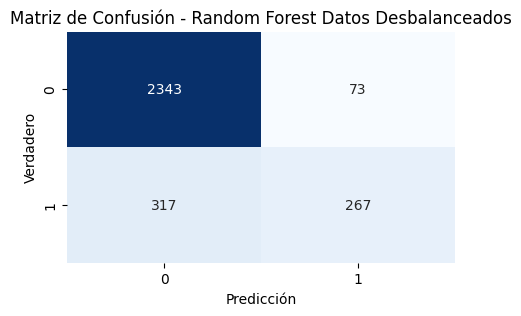

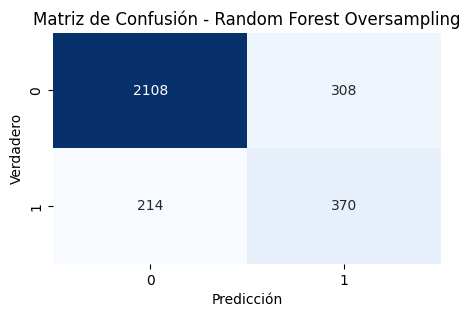

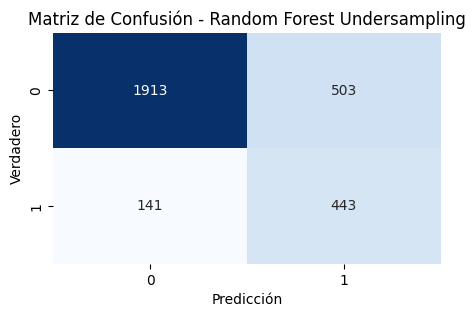

In [69]:
# Matriz de confusión
plot_confusion_matrix(y_test, y_pred_rf_esc1, 'Random Forest Datos Desbalanceados')
plot_confusion_matrix(y_test, y_pred_rf_over_esc1, 'Random Forest Oversampling')
plot_confusion_matrix(y_test, y_pred_rf_under_esc1, 'Random Forest Undersampling')

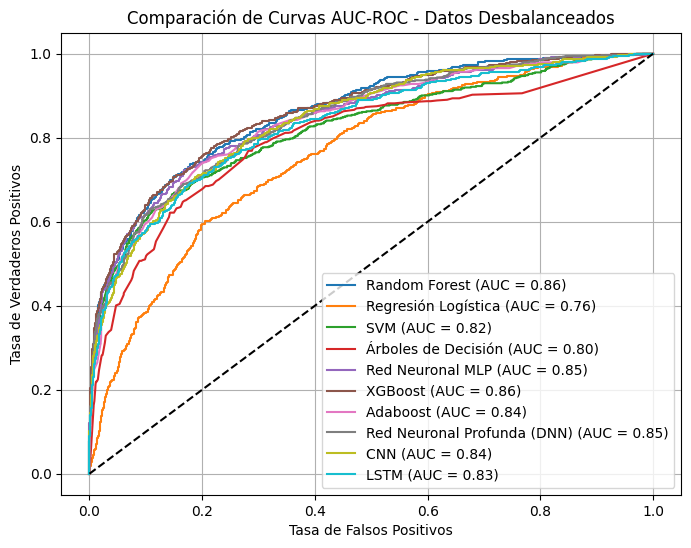

In [70]:
# Función para graficar la curva ROC
def plot_roc_curve(y_true, y_prob, titulo):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{titulo} (AUC = {auc_score:.2f})')

# Crear el gráfico de la curva ROC para Random Forest y Árboles de Decisión
plt.figure(figsize=(8, 6))

# ---------------- Gráfica para datos balanceados ---------
# Random Forest
plot_roc_curve(y_test, y_prob_rf_esc1, 'Random Forest')
# Regresión Logística
plot_roc_curve(y_test, y_prob_reglog_esc1, 'Regresión Logística')
# Support Vector Machine
plot_roc_curve(y_test, y_prob_svc_esc1, 'SVM')
# Árboles de Decisión
plot_roc_curve(y_test, y_prob_dt_esc1, 'Árboles de Decisión')
# Red Neuronal MLP
plot_roc_curve(y_test, y_prob_mlp_esc1, 'Red Neuronal MLP')
# XGBoost
plot_roc_curve(y_test, y_prob_xgb_esc1, 'XGBoost')
# AdaBoost
plot_roc_curve(y_test, y_prob_adaboost_esc1, 'Adaboost')
# Red Neuronal Profunda (DNN)
plot_roc_curve(y_test, y_pred, 'Red Neuronal Profunda (DNN)')  # Usar las probabilidades, no las etiquetas
# Red Neuronal CNN
plot_roc_curve(y_test, y_prob_cnn, 'CNN')
# Red Neuronal LSTM
plot_roc_curve(y_test, y_prob_lstm, 'LSTM')

# Gráfico final
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de Curvas AUC-ROC - Datos Desbalanceados')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

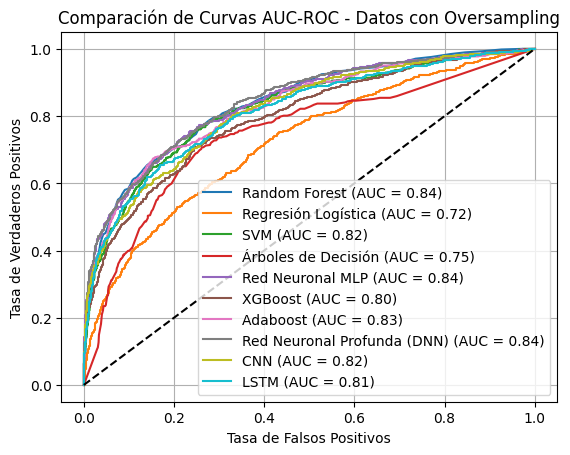

In [71]:
# ---------------- Gráfica para datos con Oversampling ---------
# Random Forest
plot_roc_curve(y_test, y_prob_rf_over_esc1, 'Random Forest')
# Regresión Logística
plot_roc_curve(y_test, y_prob_reglog_over_esc1, 'Regresión Logística')
# Support Vector Machine
plot_roc_curve(y_test, y_prob_svc_over_esc1, 'SVM')
# Árboles de Decisión
plot_roc_curve(y_test, y_prob_dt_over_esc1, 'Árboles de Decisión')
# Red Neuronal MLP
plot_roc_curve(y_test, y_prob_mlp_over_esc1, 'Red Neuronal MLP')
# XGBoost
plot_roc_curve(y_test, y_prob_xgb_over_esc1, 'XGBoost')
# AdaBoost
plot_roc_curve(y_test, y_prob_adaboost_over_esc1, 'Adaboost')

# Red Neuronal Profunda (DNN)
plot_roc_curve(y_test, y_pred_over, 'Red Neuronal Profunda (DNN)')
# Red Neuronal CNN
plot_roc_curve(y_test, y_prob_cnn_over, 'CNN')
# Red Neuronal LSTM
plot_roc_curve(y_test, y_prob_lstm_over, 'LSTM')

# Gráfico final
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de Curvas AUC-ROC - Datos con Oversampling')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

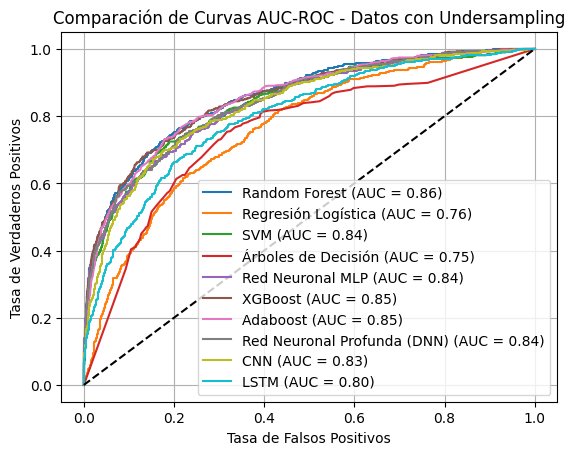

In [72]:
# ---------------- Gráfica para datos con Undersampling ---------
# Random Forest
plot_roc_curve(y_test, y_prob_rf_under_esc1, 'Random Forest')
# Regresión Logística
plot_roc_curve(y_test, y_prob_reglog_under_esc1, 'Regresión Logística')
# Support Vector Machine
plot_roc_curve(y_test, y_prob_svc_under_esc1, 'SVM')
# Árboles de Decisión
plot_roc_curve(y_test, y_prob_dt_under_esc1, 'Árboles de Decisión')
# Red Neuronal MLP
plot_roc_curve(y_test, y_prob_mlp_under_esc1, 'Red Neuronal MLP')
# XGBoost
plot_roc_curve(y_test, y_prob_xgb_under_esc1, 'XGBoost')
# AdaBoost
plot_roc_curve(y_test, y_prob_adaboost_under_esc1, 'Adaboost')

# Red Neuronal Profunda (DNN)
plot_roc_curve(y_test, y_pred_under, 'Red Neuronal Profunda (DNN)')
# Red Neuronal CNN
plot_roc_curve(y_test, y_prob_cnn_under, 'CNN')
# Red Neuronal LSTM
plot_roc_curve(y_test, y_prob_lstm_under, 'LSTM')

# Gráfico final
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de Curvas AUC-ROC - Datos con Undersampling')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()